In [12]:
import pandas as pd
import pypsa
import pycountry
import matplotlib.pyplot as plt



In [13]:
import pycountry

year = 2023

network_path = f"../results/validation_{year}/networks/base_s_39_elec_.nc"

n = pypsa.Network(network_path)

ember_load = pd.read_csv("../validation/ember_data/europe_monthly_full_release_long_format.csv")

ember_generation = pd.read_csv("../validation/ember_data/europe_monthly_full_release_long_format.csv")



countries = ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES',
       'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME',
       'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK']

color_dict = {
    "Bioenergy": "#0f9970",
    "Gas": "#87530b",
    "Hard coal": "#0000006E",
    "Hydro": "#80b1d3",
    "Lignite": "#61340c",
    "Nuclear": "#f1dd02",
    "Offshore wind": "#0c0a48",
    "Onshore wind": "#2D9FAB",
    "Other fossil": "#545454",
    "Other renewables": "#9e1414",
    "Solar": "#ffaa00"
}




INFO:pypsa.io:Imported network base_s_39_elec_.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [14]:

# Keep only Europe
ember_generation_europe = ember_generation[ember_generation["Continent"] == "Europe"].copy()

# Change ISO 3 code to ISO (using the same mapping as in ember_capacity)

def iso3_to_iso2(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).alpha_2
    except:
        return None

ember_generation_europe["ISO"] = ember_generation_europe["ISO 3 code"].apply(iso3_to_iso2)

# Filter using the previous dataset ember_capacity (keep only ISOs present in ember_capacity)
ember_generation_europe = ember_generation_europe[ember_generation_europe["ISO"].isin(countries)]
# Keep only rows where Date is in 2023
ember_generation_europe = ember_generation_europe[ember_generation_europe["Date"].str.startswith("2023")]


ember_generation_europe = ember_generation_europe[ember_generation_europe["Unit"] == "TWh"]
ember_generation_europe = ember_generation_europe[ember_generation_europe["Subcategory"] == "Fuel"]


# Keep only columns ISO, Variable, Value, and Unit
ember_generation_europe = ember_generation_europe[["ISO", "Date", "Variable", "Value", "Unit"]]

# Aggregate monthly Value to yearly per ISO and Variable
ember_generation_yearly = (
    ember_generation_europe.groupby(["ISO", "Variable"], as_index=False)["Value"].sum()
)
ember_generation_yearly["Unit"] = "TWh"
ember_generation_yearly

# Show the aggregated yearly dataframe
ember_generation_yearly = ember_generation_yearly.set_index(["ISO", "Variable"]).drop(["Unit"], axis=1)
ember_generation_yearly



Value
ISO Variable               
AT  Bioenergy          1.40
    Gas                6.44
    Hard coal          0.00
    Hydro             41.05
    Onshore wind       8.27
...                     ...
SK  Nuclear           18.31
    Onshore wind       0.00
    Other fossil       1.41
    Other renewables   0.42
    Solar              0.48

[274 rows x 1 columns]

In [15]:
# Step 1: Aggregate yearly generation for generators (in TWh) by country and technology
# n.generators_t.p columns are generator indices; map these to bus (country) and carrier (technology)

# Get mapping from generator index to bus and carrier
gen_meta = n.generators[["bus", "carrier"]]
gen_meta["country"] = gen_meta["bus"].str[:2]

# Sum yearly generation for each generator (in TWh)
gen_energy = n.generators_t.p.sum(axis=0) / 1e6  # MWh to TWh
gen_energy.index.name = "generator"
gen_energy = gen_energy.reset_index().rename(columns={0: "Value"})

# Merge meta info
gen_energy = gen_energy.merge(gen_meta, left_on="generator", right_index=True)

# Group by country and technology
gen_grouped = gen_energy.groupby(["country", "carrier"], as_index=False)["Value"].sum()

# Step 2: Map PyPSA technologies to Ember categories
pypsa_to_ember = {
    "biomass": "Bioenergy",
    "Bioenergy": "Bioenergy",
    "gas": "Gas",
    "Gas": "Gas",
    "CCGT": "Gas",
    "OCGT": "Gas",
    "coal": "Hard coal",
    "Hard coal": "Hard coal",
    "lignite": "Lignite",
    "Lignite": "Lignite",
    "hydro": "Hydro",
    "Hydro": "Hydro",
    "PHS": "Hydro",
    "ror": "Hydro",
    "Nuclear": "Nuclear",
    "nuclear": "Nuclear",
    "offwind-ac": "Offshore wind",
    "offwind-dc": "Offshore wind",
    "offwind-float": "Offshore wind",
    "Offshore wind": "Offshore wind",
    "onwind": "Onshore wind",
    "Onshore wind": "Onshore wind",
    "oil": "Other fossil",
    "Other fossil": "Other fossil",
    "geothermal": "Other renewables",
    "Other renewables": "Other renewables",
    "solar": "Solar",
    "solar-hsat": "Solar",
    "Solar": "Solar"
}

gen_grouped["Ember_Variable"] = gen_grouped["carrier"].map(pypsa_to_ember).fillna(gen_grouped["carrier"])

# Step 3: Aggregate by Ember categories
gen_renamed = gen_grouped.groupby(["country", "Ember_Variable"], as_index=False)["Value"].sum()
gen_renamed = gen_renamed.rename(columns={"country": "ISO", "Ember_Variable": "Variable"}).round()

# Show for one country (e.g., DE)
gen_renamed.query("ISO == 'DE'")


# Aggregate yearly generation for storage_units (in TWh) by country and technology
sto_meta = n.storage_units[["bus", "carrier"]]
sto_meta["country"] = sto_meta["bus"].str[:2]

sto_energy = n.storage_units_t.p.sum(axis=0) / 1e6  # MWh to TWh
sto_energy.index.name = "storage_unit"
sto_energy = sto_energy.reset_index().rename(columns={0: "Value"})

sto_energy = sto_energy.merge(sto_meta, left_on="storage_unit", right_index=True)
sto_grouped = sto_energy.groupby(["country", "carrier"], as_index=False)["Value"].sum()
sto_grouped["Ember_Variable"] = sto_grouped["carrier"].map(pypsa_to_ember).fillna(sto_grouped["carrier"])
sto_renamed = sto_grouped.groupby(["country", "Ember_Variable"], as_index=False)["Value"].sum()
sto_renamed = sto_renamed.rename(columns={"country": "ISO", "Ember_Variable": "Variable"}).round()

# Concatenate generator and storage unit yearly generation
gen_and_sto = pd.concat([gen_renamed, sto_renamed], ignore_index=True)
gen_and_sto = gen_and_sto.groupby(["ISO", "Variable"], as_index=False)["Value"].sum().round()
pypsa_generation = gen_and_sto.set_index(["ISO", "Variable"])

/tmp/ipykernel_97537/463559445.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_meta["country"] = gen_meta["bus"].str[:2]
/tmp/ipykernel_97537/463559445.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sto_meta["country"] = sto_meta["bus"].str[:2]


In [16]:
# Step 1: Aggregate yearly generation for generators (in TWh) by country and technology
# n.generators_t.p columns are generator indices; map these to bus (country) and carrier (technology)

# Get mapping from generator index to bus and carrier
gen_meta = n.generators[["bus", "carrier"]]
gen_meta["country"] = gen_meta["bus"].str[:2]

# Sum yearly generation for each generator (in TWh)
gen_energy = n.generators_t.p.sum(axis=0) / 1e6  # MWh to TWh
gen_energy.index.name = "generator"
gen_energy = gen_energy.reset_index().rename(columns={0: "Value"})

# Merge meta info
gen_energy = gen_energy.merge(gen_meta, left_on="generator", right_index=True)

# Group by country and technology
gen_grouped = gen_energy.groupby(["country", "carrier"], as_index=False)["Value"].sum()

# Step 2: Map PyPSA technologies to Ember categories
pypsa_to_ember = {
    "biomass": "Bioenergy",
    "Bioenergy": "Bioenergy",
    "gas": "Gas",
    "Gas": "Gas",
    "CCGT": "Gas",
    "OCGT": "Gas",
    "coal": "Hard coal",
    "Hard coal": "Hard coal",
    "lignite": "Lignite",
    "Lignite": "Lignite",
    "hydro": "Hydro",
    "Hydro": "Hydro",
    "PHS": "Hydro",
    "ror": "Hydro",
    "Nuclear": "Nuclear",
    "nuclear": "Nuclear",
    "offwind-ac": "Offshore wind",
    "offwind-dc": "Offshore wind",
    "offwind-float": "Offshore wind",
    "Offshore wind": "Offshore wind",
    "onwind": "Onshore wind",
    "Onshore wind": "Onshore wind",
    "oil": "Other fossil",
    "Other fossil": "Other fossil",
    "geothermal": "Other renewables",
    "Other renewables": "Other renewables",
    "solar": "Solar",
    "solar-hsat": "Solar",
    "Solar": "Solar"
}

gen_grouped["Ember_Variable"] = gen_grouped["carrier"].map(pypsa_to_ember).fillna(gen_grouped["carrier"])

# Step 3: Aggregate by Ember categories
gen_renamed = gen_grouped.groupby(["country", "Ember_Variable"], as_index=False)["Value"].sum()
gen_renamed = gen_renamed.rename(columns={"country": "ISO", "Ember_Variable": "Variable"}).round()

# Show for one country (e.g., DE)
gen_renamed.query("ISO == 'DE'")


# Aggregate yearly generation for storage_units (in TWh) by country and technology
sto_meta = n.storage_units[["bus", "carrier"]]
sto_meta["country"] = sto_meta["bus"].str[:2]

sto_energy = n.storage_units_t.p.sum(axis=0) / 1e6  # MWh to TWh
sto_energy.index.name = "storage_unit"
sto_energy = sto_energy.reset_index().rename(columns={0: "Value"})

sto_energy = sto_energy.merge(sto_meta, left_on="storage_unit", right_index=True)
sto_grouped = sto_energy.groupby(["country", "carrier"], as_index=False)["Value"].sum()
sto_grouped["Ember_Variable"] = sto_grouped["carrier"].map(pypsa_to_ember).fillna(sto_grouped["carrier"])
sto_renamed = sto_grouped.groupby(["country", "Ember_Variable"], as_index=False)["Value"].sum()
sto_renamed = sto_renamed.rename(columns={"country": "ISO", "Ember_Variable": "Variable"}).round()

# Concatenate generator and storage unit yearly generation
gen_and_sto = pd.concat([gen_renamed, sto_renamed], ignore_index=True)
gen_and_sto = gen_and_sto.groupby(["ISO", "Variable"], as_index=False)["Value"].sum().round()
pypsa_generation = gen_and_sto.set_index(["ISO", "Variable"])

/tmp/ipykernel_97537/463559445.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_meta["country"] = gen_meta["bus"].str[:2]
/tmp/ipykernel_97537/463559445.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sto_meta["country"] = sto_meta["bus"].str[:2]


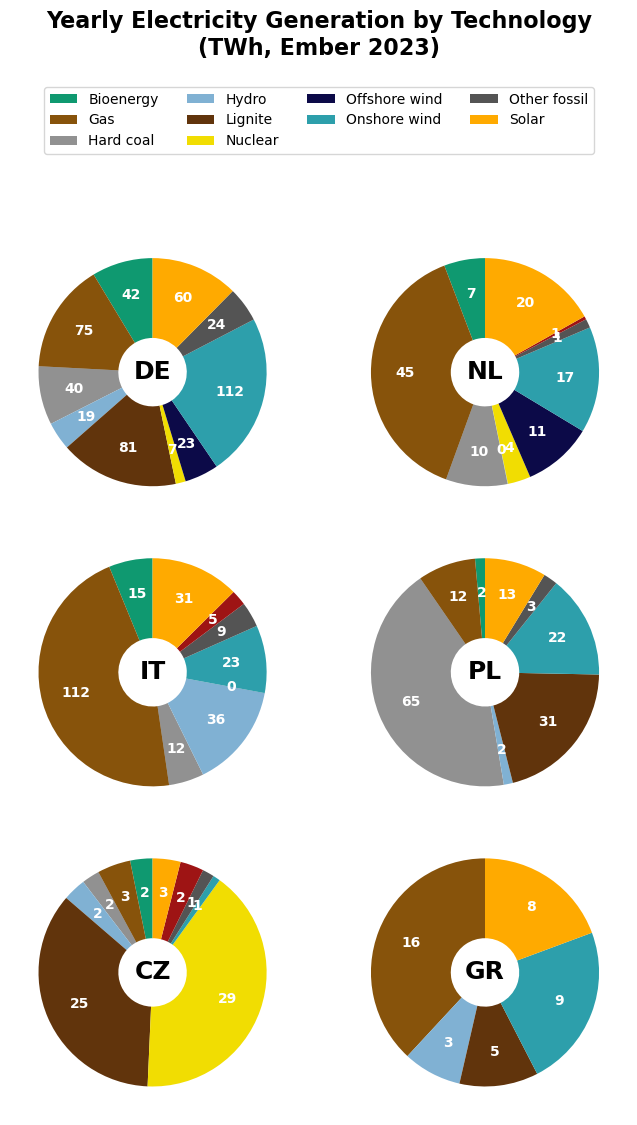

In [17]:
def plot_country_generation_mix_donut_subplots(ember_generation_yearly, country_isos, color_dict=None):
    """
    Plot yearly electricity generation mix for multiple countries as donut charts in subplots.
    Values are shown as absolute TWh. Country code is shown inside the donut.
    Technology names are not shown on the donut, only in the legend.
    Optionally, provide a color_dict mapping technology names to colors.
    """
    n = len(country_isos)
    fig, axes = plt.subplots(3, 2, figsize=(7, 10))
    axes = axes.flatten()

    # Pivot ember_generation_yearly to get [ISO, Variable] -> Value (TWh)
    pivot_df = ember_generation_yearly.unstack(level=1).fillna(0)
    pivot_df.columns = pivot_df.columns.get_level_values(1)

    legend_handles = []
    legend_labels = []

    for idx, country_iso in enumerate(country_isos):
        ax = axes[idx]
        if country_iso not in pivot_df.index:
            ax.axis('off')
            ax.set_title(f"{country_iso} not found")
            continue

        data = pivot_df.loc[country_iso]
        data = data[data > 0]  # Only plot nonzero values

        # Choose colors
        if color_dict is not None:
            colors = [color_dict.get(tech, "#cccccc") for tech in data.index]
        else:
            colors = sns.color_palette("Set2", len(data))

        wedges, texts = ax.pie(
            data.values,
            labels=None,  # Remove technology names from donut
            startangle=90,
            colors=colors,
            wedgeprops=dict(width=0.7),
            autopct=None
        )

        # Add absolute values as labels manually (in red)
        for i, wedge in enumerate(wedges):
            angle = (wedge.theta2 + wedge.theta1) / 2
            x = 0.7 * np.cos(np.deg2rad(angle))
            y = 0.7 * np.sin(np.deg2rad(angle))
            ax.text(x, y, f"{int(round(data.values[i]))}", ha='center', va='center', fontsize=10, color='white', fontweight='bold')

        # Draw smaller white circle for donut and add country code inside
        centre_circle = plt.Circle((0, 0), 0.25, color='white', fc='white', linewidth=0)
        ax.add_artist(centre_circle)
        ax.text(0, 0, country_iso, ha='center', va='center', fontsize=18, fontweight='bold')

        # Collect legend handles and labels from the first subplot
        if idx == 0:
            legend_handles = wedges
            legend_labels = data.index

    # Hide unused subplots
    for j in range(len(country_isos), len(axes)):
        axes[j].axis('off')

    # Add legend above the charts, 3 columns, spanning the figure width
    fig.legend(
        legend_handles, legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=4,
        fontsize=10,
        frameon=True
    )

    fig.suptitle("Yearly Electricity Generation by Technology\n(TWh, Ember 2023)", fontsize=16, weight='bold', y=1.12)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


plot_country_generation_mix_donut_subplots(ember_generation_yearly, ["DE", "NL", "IT", "PL", "CZ", "GR"], color_dict=color_dict)

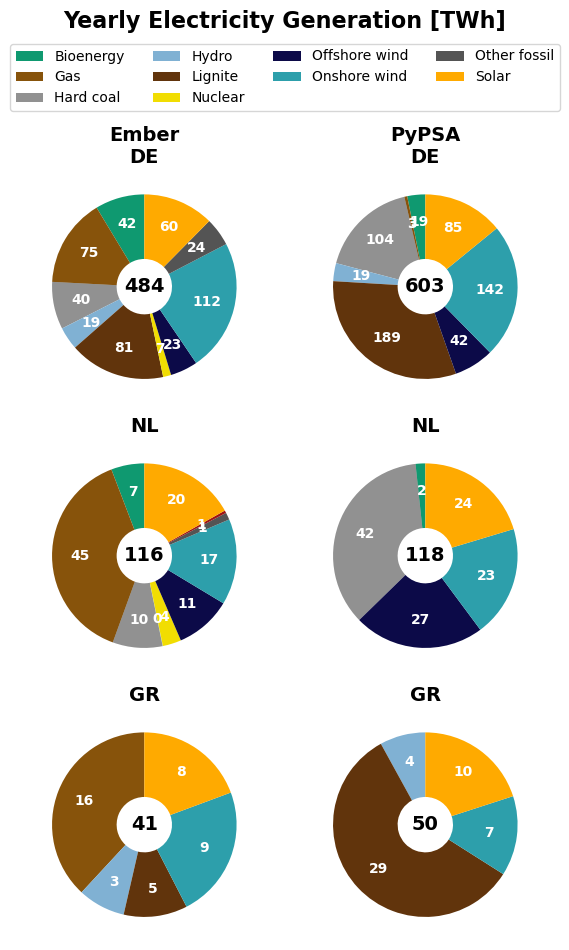

In [18]:
import numpy as np

def plot_country_generation_mix_donut_comparison(df1, df2, country_isos, color_dict=None, df1_label="Ember", df2_label="PyPSA"):

    n = len(country_isos)
    fig, axes = plt.subplots(n, 2, figsize=(6, 3 * n))
    plt.subplots_adjust(wspace=0.05)
    if n == 1:
        axes = np.array([axes])
    legend_handles = []
    legend_labels = []

    def pivot(df):
        if isinstance(df.index, pd.MultiIndex):
            p = df.unstack(level=1).fillna(0)
            p.columns = p.columns.get_level_values(1)
        else:
            p = df.copy()
        return p

    pivot1 = pivot(df1)
    pivot2 = pivot(df2)

    for idx, country_iso in enumerate(country_isos):
        for j, (pivot_df, label) in enumerate(zip([pivot1, pivot2], [df1_label, df2_label])):
            ax = axes[idx, j]
            if country_iso not in pivot_df.index:
                ax.axis('off')
                ax.set_title(f"{country_iso} not found")
                continue
            data = pivot_df.loc[country_iso]
            data = data[data > 0]
            if color_dict is not None:
                colors = [color_dict.get(tech, "#cccccc") for tech in data.index]
            else:
                colors = plt.cm.Set2.colors[:len(data)]
            wedges, _ = ax.pie(
                data.values,
                labels=None,
                startangle=90,
                colors=colors,
                wedgeprops=dict(width=0.7),
                autopct=None
            )
            for i, wedge in enumerate(wedges):
                angle = (wedge.theta2 + wedge.theta1) / 2
                x = 0.7 * np.cos(np.deg2rad(angle))
                y = 0.7 * np.sin(np.deg2rad(angle))
                ax.text(x, y, f"{int(round(data.values[i]))}", ha='center', va='center', fontsize=10, color='white', fontweight='bold')
            centre_circle = plt.Circle((0, 0), 0.25, color='white', fc='white', linewidth=0)
            ax.add_artist(centre_circle)
            total = int(round(data.sum()))
            ax.text(0, 0, f"{total}", ha='center', va='center', fontsize=14, fontweight='bold')
            # Set country code as title for each donut
            ax.set_title(country_iso, fontsize=14, fontweight='bold')
            if idx == 0:
                if j == 0:
                    ax.set_title(f"{df1_label}\n{country_iso}", fontsize=14, fontweight='bold')
                else:
                    ax.set_title(f"{df2_label}\n{country_iso}", fontsize=14, fontweight='bold')
            if idx == 0 and j == 0:
                legend_handles = wedges
                legend_labels = data.index
    for i in range(n, axes.shape[0]):
        for j in range(2):
            axes[i, j].axis('off')
    fig.legend(
        legend_handles, legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=4,
        fontsize=10,
        frameon=True
    )
    fig.suptitle("Yearly Electricity Generation [TWh]", fontsize=16, weight='bold', y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    plt.show()

plot_country_generation_mix_donut_comparison(ember_generation_yearly, pypsa_generation, ["DE", "NL", "GR"], color_dict=color_dict, df1_label="Ember", df2_label="PyPSA")
